In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10

# import parameters
#from model_params import *


In [38]:
img_rows, img_cols, img_chns = 260, 172, 3
latent_dim = 16
intermediate_dim = 128
epsilon_std = 1.0
epochs = 30
filters = 5
num_conv = 3
batch_size = 150

In [39]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

show_name = "all"
src_dir = "../img/%s" % show_name
input_files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if f.endswith(".jpg")]

imgs = [Image.open(im).resize((172, 260)) for im in input_files]
lwf_immatrix = np.array([np.array(im) for im in imgs])

#lwf_immatrix = np.array([np.array(Image.open(im)) for im in input_files])
print("Input size", lwf_immatrix.shape)


x_train, x_test, _, _ = train_test_split(lwf_immatrix, [0]*len(input_files), test_size=0.20, random_state=42)

original_img_size = lwf_immatrix[0].shape

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
print(original_img_size)
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)


Input size (195, 260, 172, 3)
(260, 172, 3)
(156, 260, 172, 3)


In [41]:
# tensorflow uses channels_last
# theano uses channels_first
"""
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
"""
#original_img_size = (img_rows, img_cols, img_chns)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(int(filters * round(img_rows / 2) * round(img_cols / 2)), activation='relu')

output_shape = (batch_size, int(round(img_rows / 2)), int(round(img_cols / 2)), filters)
"""
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
else:
    output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)
"""    

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])

# entire model
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 260, 172, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 260, 172, 3)  39          input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 130, 86, 5)   65          conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 130, 86, 5)   230         conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_24 

In [ ]:
# training
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator
vae.save('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
generator.save('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs))

# save training history
fname = '../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 156 samples, validate on 39 samples
Epoch 1/30
156/156 [==============================] - 11s 71ms/step - loss: 32638.3658 - val_loss: 30797.2812
Epoch 2/30
156/156 [==============================] - 10s 65ms/step - loss: 32602.3675 - val_loss: 30739.8008
Epoch 3/30
156/156 [==============================] - 10s 65ms/step - loss: 32224.8323 - val_loss: 30774.1895
Epoch 4/30
156/156 [==============================] - 10s 66ms/step - loss: 32463.7460 - val_loss: 32065.9414
Epoch 5/30
156/156 [==============================] - 10s 65ms/step - loss: 34678.4219 - val_loss: 30807.3496
Epoch 6/30
156/156 [==============================] - 10s 65ms/step - loss: 32436.3214 - val_loss: 30795.4844
Epoch 7/30


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import pickle

if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[1]*len(x_test))
    plt.colorbar()
    plt.show()

    

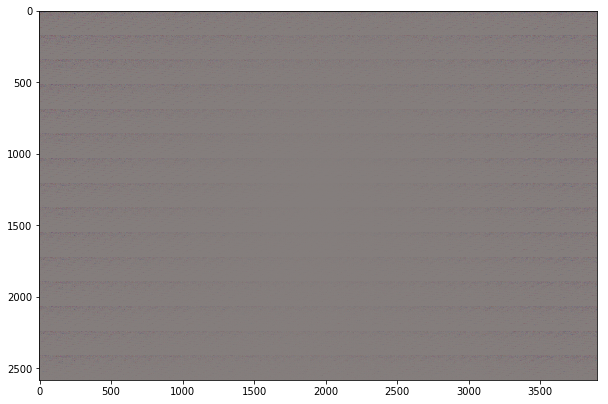

In [13]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
#digit_size = 28
width = img_cols
height = img_rows
figure = np.zeros((width * n, height * n, img_chns))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = generator.predict(z_sample)
        print(x_decoded)
        img = x_decoded[0].reshape(width, height, img_chns)
        figure[i * width: (i + 1) * width,
               j * height: (j + 1) * height] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

[[[ 0.65272236  0.6297403   0.60145617]
  [ 0.65284473  0.62562007  0.59822547]
  [ 0.65050721  0.62308764  0.59964031]
  ..., 
  [ 0.65541828  0.61836147  0.60196817]
  [ 0.65131485  0.61695421  0.59759724]
  [ 0.65448606  0.61503887  0.6001628 ]]

 [[ 0.65005785  0.61798531  0.59848785]
  [ 0.65181142  0.61733067  0.60243517]
  [ 0.64976764  0.61625922  0.60073489]
  ..., 
  [ 0.65468097  0.61871594  0.6033982 ]
  [ 0.65136421  0.61754155  0.6021015 ]
  [ 0.65207738  0.61880594  0.60302842]]

 [[ 0.65037417  0.61859459  0.60074639]
  [ 0.65372914  0.61893296  0.60375577]
  [ 0.65125966  0.61791337  0.60176301]
  ..., 
  [ 0.64798993  0.62044477  0.59572256]
  [ 0.64723736  0.61596912  0.59760827]
  [ 0.64904076  0.61905897  0.59731168]]

 ..., 
 [[ 0.66144329  0.633066    0.60922706]
  [ 0.66041559  0.63373792  0.60879236]
  [ 0.66117299  0.63087207  0.60892034]
  ..., 
  [ 0.66457558  0.63141745  0.60818183]
  [ 0.6625064   0.63270062  0.60754764]
  [ 0.66373396  0.63179487  0.60993

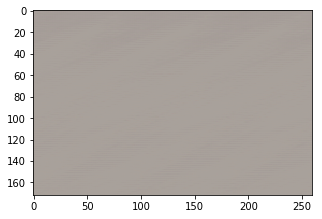

[[[ 0.64997649  0.62841314  0.60162175]
  [ 0.65066469  0.62352538  0.59747094]
  [ 0.64613426  0.62185788  0.59805006]
  ..., 
  [ 0.65309823  0.61780381  0.60205913]
  [ 0.6497646   0.61680388  0.5986551 ]
  [ 0.65186495  0.61517519  0.6002335 ]]

 [[ 0.64800006  0.61492795  0.59736842]
  [ 0.65102708  0.61552119  0.60211396]
  [ 0.64859283  0.61537737  0.59888119]
  ..., 
  [ 0.65325463  0.61799943  0.60197449]
  [ 0.65023828  0.61672622  0.6011824 ]
  [ 0.65141428  0.61696976  0.60306066]]

 [[ 0.64983004  0.61588985  0.60148621]
  [ 0.6519348   0.61778861  0.60283667]
  [ 0.65004134  0.61666948  0.60043794]
  ..., 
  [ 0.6446836   0.61542076  0.592085  ]
  [ 0.6448704   0.61133081  0.5943948 ]
  [ 0.64722908  0.616642    0.59542763]]

 ..., 
 [[ 0.66147333  0.63365942  0.60996491]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

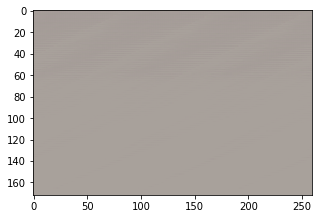

[[[ 0.65128875  0.62910199  0.60225016]
  [ 0.65163791  0.62466264  0.59829408]
  [ 0.64754486  0.62278515  0.59897316]
  ..., 
  [ 0.6561085   0.62034267  0.6035676 ]
  [ 0.65192109  0.62003535  0.5995819 ]
  [ 0.65429837  0.61857051  0.60263258]]

 [[ 0.65140092  0.61987817  0.59986836]
  [ 0.65351218  0.61979985  0.60271484]
  [ 0.65084547  0.61957049  0.60036367]
  ..., 
  [ 0.6539101   0.61920929  0.60187632]
  [ 0.65037191  0.61748731  0.60094559]
  [ 0.65291166  0.61808771  0.60296416]]

 [[ 0.65037537  0.61873585  0.60020739]
  [ 0.65337539  0.61989987  0.6036129 ]
  [ 0.65152156  0.61905861  0.60152876]
  ..., 
  [ 0.64846981  0.61954641  0.5956865 ]
  [ 0.64906275  0.61603081  0.59768593]
  [ 0.65066701  0.62075734  0.59908694]]

 ..., 
 [[ 0.66120881  0.63319594  0.60908318]
  [ 0.66099668  0.633708    0.60953963]
  [ 0.66125202  0.63249701  0.60954452]
  ..., 
  [ 0.66200459  0.63308209  0.61016846]
  [ 0.66135931  0.63353622  0.60950851]
  [ 0.66207528  0.63291025  0.61030

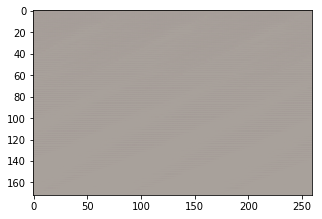

[[[ 0.65385693  0.6302079   0.60220122]
  [ 0.65436137  0.62657791  0.59996903]
  [ 0.65305662  0.62456328  0.60126185]
  ..., 
  [ 0.65357894  0.61585635  0.60124135]
  [ 0.64850181  0.61519361  0.59678036]
  [ 0.65205991  0.61328399  0.60020554]]

 [[ 0.64787835  0.6146403   0.59688735]
  [ 0.65014613  0.61440521  0.60113108]
  [ 0.64774895  0.61316109  0.59884179]
  ..., 
  [ 0.65592176  0.62123275  0.60478652]
  [ 0.65309918  0.62083334  0.6033954 ]
  [ 0.65417123  0.62118298  0.60368663]]

 [[ 0.6520384   0.62088621  0.60230863]
  [ 0.65493113  0.62146342  0.60558838]
  [ 0.6531629   0.62100399  0.60353339]
  ..., 
  [ 0.64430285  0.61639154  0.59175503]
  [ 0.64364308  0.61109906  0.5941034 ]
  [ 0.6464712   0.61528403  0.59477907]]

 ..., 
 [[ 0.661026    0.63284469  0.60837221]
  [ 0.66048461  0.63336098  0.60879147]
  [ 0.66092575  0.63092858  0.60890073]
  ..., 
  [ 0.6628722   0.63209832  0.61033446]
  [ 0.6612252   0.633452    0.60886037]
  [ 0.6626544   0.63213098  0.61041

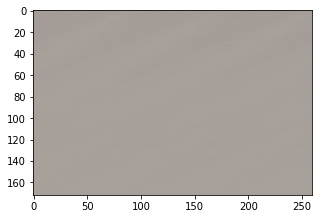

[[[ 0.63245058  0.62042546  0.5921253 ]
  [ 0.63627636  0.60818624  0.58122438]
  [ 0.62228209  0.60700339  0.58245254]
  ..., 
  [ 0.64544874  0.60603964  0.59602785]
  [ 0.64086819  0.60502905  0.59072983]
  [ 0.64602935  0.60345745  0.59546232]]

 [[ 0.64007598  0.60103291  0.59098887]
  [ 0.64307481  0.60218364  0.59459144]
  [ 0.63863075  0.60106367  0.58953732]
  ..., 
  [ 0.64074773  0.59536141  0.59058219]
  [ 0.63421392  0.59354061  0.58669418]
  [ 0.63778365  0.59618324  0.5940938 ]]

 [[ 0.63494283  0.59328789  0.58932805]
  [ 0.64068472  0.59750706  0.59235907]
  [ 0.63532561  0.59559178  0.58665514]
  ..., 
  [ 0.6335718   0.60349107  0.57881457]
  [ 0.63624251  0.59482837  0.58372259]
  [ 0.63771248  0.60644734  0.58518344]]

 ..., 
 [[ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

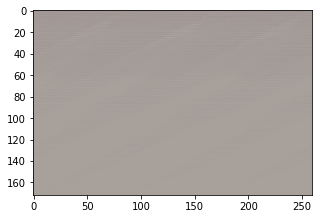

[[[ 0.63651448  0.622293    0.5946523 ]
  [ 0.63923424  0.61179239  0.58448321]
  [ 0.62649512  0.6102398   0.5856176 ]
  ..., 
  [ 0.64810055  0.61015946  0.59824789]
  [ 0.64397645  0.60866493  0.59409046]
  [ 0.6482898   0.60853082  0.59798521]]

 [[ 0.64346004  0.60734624  0.59324437]
  [ 0.64675444  0.60774958  0.59715641]
  [ 0.64267921  0.60654718  0.59308159]
  ..., 
  [ 0.64400232  0.6014992   0.59371173]
  [ 0.63850725  0.59984803  0.59042674]
  [ 0.64157689  0.60151666  0.59622079]]

 [[ 0.63872153  0.59889054  0.59210598]
  [ 0.64343935  0.60272104  0.59489596]
  [ 0.6389522   0.60132009  0.58954269]
  ..., 
  [ 0.63792175  0.6083172   0.5836972 ]
  [ 0.64018911  0.60095185  0.58773875]
  [ 0.64125174  0.61060625  0.58888626]]

 ..., 
 [[ 0.6613465   0.63300842  0.6098175 ]
  [ 0.66112167  0.63367057  0.60968012]
  [ 0.66125917  0.63281369  0.60968828]
  ..., 
  [ 0.66148877  0.63357776  0.61009175]
  [ 0.66156107  0.6335122   0.60993761]
  [ 0.6615175   0.63365382  0.61006

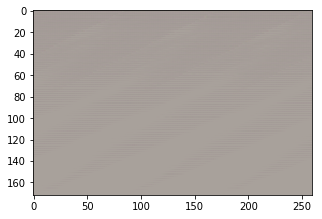

[[[ 0.64777708  0.62737805  0.60113198]
  [ 0.64892495  0.62170655  0.59583491]
  [ 0.64261514  0.62038338  0.59633273]
  ..., 
  [ 0.65303177  0.61673695  0.60173136]
  [ 0.64909148  0.61604667  0.597857  ]
  [ 0.65168351  0.61525673  0.60082752]]

 [[ 0.64817268  0.6145643   0.59747612]
  [ 0.65051562  0.61538225  0.60133088]
  [ 0.64815968  0.61468041  0.59823221]
  ..., 
  [ 0.65182829  0.61588001  0.60038936]
  [ 0.64814174  0.6143232   0.59908009]
  [ 0.6508292   0.61471486  0.60163313]]

 [[ 0.64815634  0.61448908  0.59914517]
  [ 0.65109575  0.61652118  0.60214186]
  [ 0.64908987  0.61561936  0.59949994]
  ..., 
  [ 0.64399815  0.61470222  0.59116662]
  [ 0.64464784  0.6101411   0.59370369]
  [ 0.64672041  0.6161049   0.5948844 ]]

 ..., 
 [[ 0.66135448  0.63338774  0.60967618]
  [ 0.66138136  0.63373786  0.61003345]
  [ 0.66137624  0.63362527  0.60992026]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

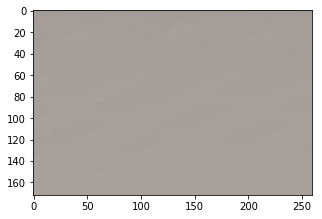

[[[ 0.63905424  0.62340426  0.59595919]
  [ 0.64120913  0.61403084  0.58677584]
  [ 0.62992811  0.61228997  0.58778214]
  ..., 
  [ 0.64772874  0.6091615   0.59585828]
  [ 0.64225215  0.60939699  0.59015322]
  [ 0.64994979  0.60554701  0.59735149]]

 [[ 0.64272958  0.60441542  0.59368283]
  [ 0.6446659   0.6060698   0.59688532]
  [ 0.64147401  0.60544401  0.59255117]
  ..., 
  [ 0.64480317  0.60168731  0.59361881]
  [ 0.63871938  0.59884256  0.59178948]
  [ 0.64122838  0.60108471  0.59611517]]

 [[ 0.63843918  0.59950036  0.59179509]
  [ 0.64374751  0.60247183  0.59494001]
  [ 0.63907439  0.60039908  0.5905354 ]
  ..., 
  [ 0.63615507  0.60550934  0.58374196]
  [ 0.63640982  0.60019082  0.5870049 ]
  [ 0.63968551  0.60843426  0.58737493]]

 ..., 
 [[ 0.65968943  0.63015687  0.60522175]
  [ 0.65913415  0.63169825  0.60665506]
  [ 0.66015881  0.62999409  0.60642695]
  ..., 
  [ 0.66444868  0.63118726  0.6086027 ]
  [ 0.66253388  0.63236088  0.60666221]
  [ 0.66377014  0.63193232  0.60896

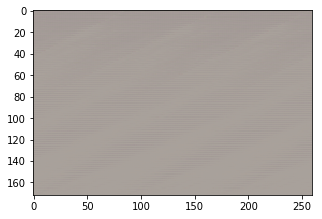

[[[ 0.63437414  0.6213088   0.59332055]
  [ 0.63775283  0.60988814  0.58287644]
  [ 0.62445486  0.60860318  0.58404547]
  ..., 
  [ 0.64248854  0.60138547  0.59305435]
  [ 0.63690263  0.60122997  0.5860635 ]
  [ 0.64422613  0.5980953   0.5930472 ]]

 [[ 0.63667256  0.59512615  0.58848178]
  [ 0.63950068  0.59722847  0.59256583]
  [ 0.63507628  0.59619588  0.58675194]
  ..., 
  [ 0.64172584  0.59650612  0.59126562]
  [ 0.63527972  0.59430909  0.58837301]
  [ 0.63801742  0.59690613  0.59468341]]

 [[ 0.63556463  0.59398335  0.59033465]
  [ 0.64112657  0.59834415  0.59289354]
  [ 0.63597202  0.59632158  0.58740366]
  ..., 
  [ 0.62874162  0.5990513   0.57535446]
  [ 0.62847388  0.59017766  0.5800674 ]
  [ 0.6334846   0.59963363  0.58113211]]

 ..., 
 [[ 0.66104561  0.63260919  0.60914111]
  [ 0.66091537  0.63356841  0.60960233]
  [ 0.66108716  0.6324361   0.60934299]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

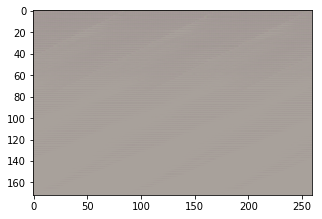

[[[ 0.63947147  0.62365514  0.59649539]
  [ 0.64250982  0.61435473  0.58847505]
  [ 0.63216299  0.61360025  0.58932579]
  ..., 
  [ 0.64908224  0.61146247  0.59877759]
  [ 0.64517826  0.61029834  0.59458178]
  [ 0.64813763  0.60868603  0.59763455]]

 [[ 0.64357042  0.60638773  0.59425288]
  [ 0.64602673  0.60795408  0.59763014]
  [ 0.64276105  0.60724831  0.59331399]
  ..., 
  [ 0.64543271  0.60279697  0.59431499]
  [ 0.63970739  0.60066205  0.59190416]
  [ 0.64176917  0.60378134  0.597592  ]]

 [[ 0.6401723   0.60207373  0.5933243 ]
  [ 0.64543265  0.60526907  0.59620035]
  [ 0.6409992   0.60331774  0.59189284]
  ..., 
  [ 0.63785064  0.60737175  0.58447808]
  [ 0.63950425  0.60146594  0.58808029]
  [ 0.64186186  0.61046916  0.58972728]]

 ..., 
 [[ 0.66150057  0.63361579  0.6100738 ]
  [ 0.66148001  0.63364184  0.61007988]
  [ 0.66149831  0.63363475  0.61006981]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

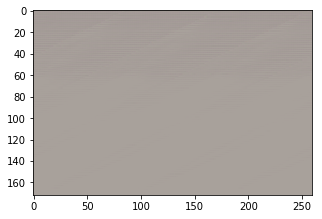

[[[ 0.65133274  0.62907678  0.60260564]
  [ 0.65154845  0.62475145  0.59837043]
  [ 0.64704686  0.62288672  0.59896499]
  ..., 
  [ 0.65712357  0.62454051  0.60587078]
  [ 0.65503824  0.62237632  0.60460138]
  [ 0.65545118  0.62412542  0.60406125]]

 [[ 0.65443081  0.62518466  0.60162473]
  [ 0.65672278  0.62422365  0.60359466]
  [ 0.65403211  0.62326443  0.6024633 ]
  ..., 
  [ 0.65447205  0.61960226  0.60201776]
  [ 0.65074033  0.6183778   0.60089535]
  [ 0.65365177  0.61872137  0.6029337 ]]

 [[ 0.65081292  0.61942804  0.60048681]
  [ 0.6535297   0.6203109   0.60395801]
  [ 0.65185821  0.61937433  0.60201466]
  ..., 
  [ 0.6553269   0.62851596  0.60270983]
  [ 0.65467525  0.62534755  0.60403442]
  [ 0.65509468  0.62609249  0.60340315]]

 ..., 
 [[ 0.66123807  0.63328433  0.60913515]
  [ 0.660721    0.63402992  0.60925305]
  [ 0.66131407  0.63200897  0.60904682]
  ..., 
  [ 0.66381609  0.63126314  0.60993856]
  [ 0.66147625  0.63314962  0.6078651 ]
  [ 0.66367638  0.63141185  0.61043

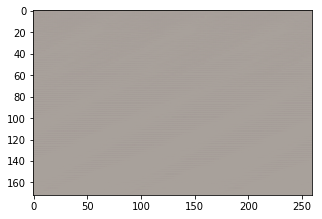

[[[ 0.65082747  0.62889624  0.60177666]
  [ 0.65096289  0.62424916  0.59735268]
  [ 0.64648151  0.62202483  0.59814489]
  ..., 
  [ 0.65747172  0.62216431  0.60410482]
  [ 0.65400702  0.62073421  0.60065275]
  [ 0.65553105  0.62025476  0.60150665]]

 [[ 0.6523509   0.62223315  0.60008228]
  [ 0.65542978  0.62104595  0.60239768]
  [ 0.65167338  0.62117958  0.60027069]
  ..., 
  [ 0.65363914  0.61808378  0.60120076]
  [ 0.6496647   0.61609221  0.60066891]
  [ 0.65230489  0.61682767  0.60234833]]

 [[ 0.64951849  0.61762011  0.59957057]
  [ 0.65281665  0.61909044  0.60325772]
  [ 0.65097982  0.6183337   0.60124171]
  ..., 
  [ 0.65253216  0.62391096  0.59832573]
  [ 0.65325308  0.62071079  0.6009782 ]
  [ 0.6532979   0.6245417   0.60174203]]

 ..., 
 [[ 0.66103572  0.63307279  0.60878271]
  [ 0.66088676  0.6341415   0.60967964]
  [ 0.66107589  0.63319391  0.60903007]
  ..., 
  [ 0.66378701  0.63146114  0.61004627]
  [ 0.66146225  0.63345587  0.60790968]
  [ 0.66389775  0.63125587  0.61059

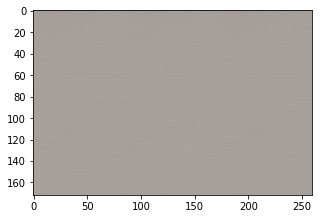

[[[ 0.65279919  0.62990046  0.60236949]
  [ 0.65254873  0.62588459  0.59848607]
  [ 0.64914334  0.6233288   0.59956259]
  ..., 
  [ 0.66016757  0.62960315  0.60788584]
  [ 0.6593762   0.6282025   0.60684764]
  [ 0.65803117  0.62976325  0.60615641]]

 [[ 0.6595943   0.6295585   0.60666525]
  [ 0.65914577  0.62850589  0.60469592]
  [ 0.65737855  0.62631464  0.60355747]
  ..., 
  [ 0.65603769  0.61971682  0.60228795]
  [ 0.65126514  0.61823791  0.60205173]
  [ 0.65334249  0.61890942  0.60327983]]

 [[ 0.65097207  0.61982149  0.600869  ]
  [ 0.65384889  0.62036014  0.60397267]
  [ 0.65207082  0.6192497   0.60272759]
  ..., 
  [ 0.65980369  0.63331461  0.60630679]
  [ 0.65603292  0.6310119   0.60614324]
  [ 0.6575985   0.62722725  0.60455841]]

 ..., 
 [[ 0.66132301  0.63327157  0.60979933]
  [ 0.66101038  0.63414496  0.60964292]
  [ 0.66113961  0.63320029  0.60899729]
  ..., 
  [ 0.66472894  0.63110155  0.60943693]
  [ 0.66272497  0.63289893  0.60732019]
  [ 0.66390717  0.63194412  0.60913

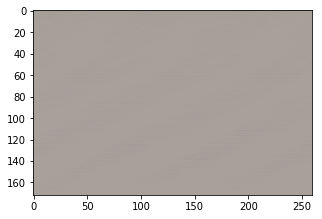

[[[ 0.65077776  0.62885106  0.6018846 ]
  [ 0.65097171  0.62422055  0.59747648]
  [ 0.64642924  0.62210155  0.59821218]
  ..., 
  [ 0.65736181  0.62146682  0.60321528]
  [ 0.65409726  0.61905026  0.59999722]
  [ 0.65647691  0.61906725  0.60034186]]

 [[ 0.65217477  0.62295717  0.59972173]
  [ 0.65540802  0.6208573   0.60284042]
  [ 0.65179676  0.620444    0.60149276]
  ..., 
  [ 0.65366781  0.61846113  0.60144663]
  [ 0.64991736  0.61673862  0.60066253]
  [ 0.65280408  0.61724937  0.6023615 ]]

 [[ 0.64982986  0.61795175  0.59982508]
  [ 0.65280318  0.61900157  0.60330325]
  [ 0.65095544  0.61803347  0.60134041]
  ..., 
  [ 0.65223247  0.62451303  0.59796214]
  [ 0.65272111  0.6204021   0.60054612]
  [ 0.65339285  0.62378079  0.6020419 ]]

 ..., 
 [[ 0.66026318  0.6323632   0.60716712]
  [ 0.66024876  0.63353777  0.60858041]
  [ 0.66103089  0.63135147  0.60816568]
  ..., 
  [ 0.66470557  0.63089353  0.60848808]
  [ 0.6620912   0.63249332  0.60686219]
  [ 0.66365069  0.63169897  0.60952

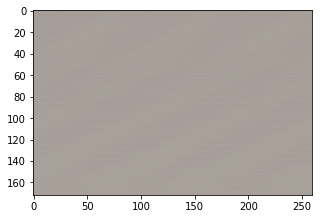

[[[ 0.65380764  0.63060981  0.60329139]
  [ 0.65483445  0.62676626  0.60116374]
  [ 0.65263903  0.62534112  0.6016075 ]
  ..., 
  [ 0.65274656  0.616723    0.6015867 ]
  [ 0.64905727  0.61517912  0.59814823]
  [ 0.65106338  0.61429805  0.59969944]]

 [[ 0.64725375  0.61458194  0.59619856]
  [ 0.65070158  0.6144979   0.60152489]
  [ 0.64789718  0.61372453  0.59854543]
  ..., 
  [ 0.65606314  0.62312657  0.60504144]
  [ 0.65384001  0.62255281  0.60369796]
  [ 0.65492088  0.62183422  0.60443825]]

 [[ 0.65290529  0.62082386  0.60353798]
  [ 0.65464187  0.62306404  0.60550016]
  [ 0.65369409  0.62346226  0.60313594]
  ..., 
  [ 0.64405817  0.61562777  0.59167808]
  [ 0.64372683  0.61072868  0.59398353]
  [ 0.64643353  0.61525553  0.5947004 ]]

 ..., 
 [[ 0.6611889   0.63307315  0.60894769]
  [ 0.66114926  0.63368219  0.60987991]
  [ 0.66124195  0.63317209  0.60982352]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

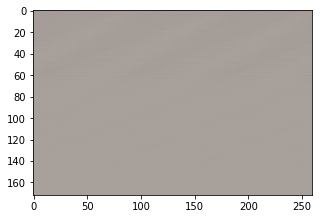

[[[ 0.65344274  0.63041985  0.60405809]
  [ 0.65442991  0.62658143  0.60161525]
  [ 0.651452    0.62561661  0.60188115]
  ..., 
  [ 0.65603536  0.62052083  0.60336465]
  [ 0.65184021  0.61863822  0.60039014]
  [ 0.65276915  0.61806619  0.60150403]]

 [[ 0.6500659   0.62058669  0.59770215]
  [ 0.65403771  0.61913127  0.60303062]
  [ 0.650747    0.61817801  0.60143965]
  ..., 
  [ 0.65598267  0.62351376  0.60454309]
  [ 0.65367663  0.62254435  0.60315824]
  [ 0.65511113  0.62174892  0.60389709]]

 [[ 0.65252256  0.62119281  0.60253292]
  [ 0.65501356  0.62298506  0.60530174]
  [ 0.65363473  0.62364978  0.60275346]
  ..., 
  [ 0.64861846  0.62051755  0.59539318]
  [ 0.64934605  0.61580396  0.59783536]
  [ 0.65034389  0.6205588   0.59870827]]

 ..., 
 [[ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

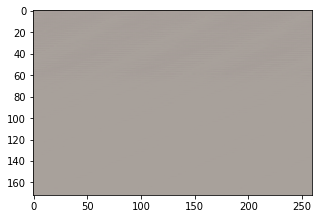

[[[ 0.64126921  0.62448472  0.59761786]
  [ 0.64338571  0.6159783   0.5892958 ]
  [ 0.63301778  0.61464709  0.59018844]
  ..., 
  [ 0.64883447  0.61087298  0.59764206]
  [ 0.6436457   0.60972887  0.59317738]
  [ 0.65001261  0.60923433  0.59891427]]

 [[ 0.6443727   0.60968626  0.59350997]
  [ 0.64772809  0.60900313  0.5980866 ]
  [ 0.64388376  0.60721016  0.59513807]
  ..., 
  [ 0.64718676  0.60823739  0.59707004]
  [ 0.64298022  0.60662407  0.59500515]
  [ 0.64624095  0.60755783  0.5986982 ]]

 [[ 0.64318711  0.60598379  0.59569675]
  [ 0.64673966  0.60849118  0.59803402]
  [ 0.64328188  0.60701007  0.59405947]
  ..., 
  [ 0.63897187  0.61126971  0.58542442]
  [ 0.6388011   0.60359663  0.58882481]
  [ 0.6416133   0.60983521  0.58956009]]

 ..., 
 [[ 0.65953785  0.63054091  0.60477298]
  [ 0.65934348  0.63200277  0.60671157]
  [ 0.66037589  0.63044631  0.60627908]
  ..., 
  [ 0.66452253  0.63078594  0.60915357]
  [ 0.66219449  0.63229561  0.60661173]
  [ 0.66358346  0.63184404  0.60938

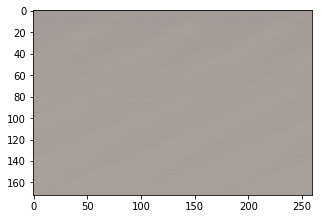

[[[ 0.64264858  0.62512195  0.59848011]
  [ 0.64445734  0.61720163  0.59050196]
  [ 0.63459945  0.61580789  0.59135002]
  ..., 
  [ 0.65295786  0.61807883  0.60223711]
  [ 0.64990598  0.61700714  0.5991779 ]
  [ 0.65220225  0.61596507  0.60142732]]

 [[ 0.6488477   0.61502433  0.59825641]
  [ 0.65086752  0.61561531  0.60093874]
  [ 0.64805192  0.61497396  0.59772962]
  ..., 
  [ 0.64810687  0.60794312  0.59650654]
  [ 0.64299291  0.60587496  0.59513056]
  [ 0.64517784  0.60701001  0.5988223 ]]

 [[ 0.64281189  0.60563958  0.59581953]
  [ 0.64685684  0.60885781  0.59829396]
  [ 0.64365405  0.60756123  0.59484428]
  ..., 
  [ 0.64467514  0.61422431  0.59134227]
  [ 0.64733708  0.60991174  0.5943014 ]
  [ 0.64767337  0.61821282  0.59569854]]

 ..., 
 [[ 0.66150612  0.63364309  0.61006862]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  ..., 
  [ 0.66144991  0.63366431  0.60996813]
  [ 0.66135079  0.6336025   0.60997659]
  [ 0.66145575  0.63351643  0.61004

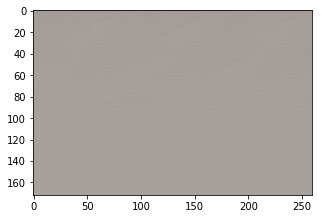

[[[ 0.6556707   0.63098294  0.60343289]
  [ 0.65546066  0.62816346  0.60091269]
  [ 0.65410596  0.62581015  0.60239983]
  ..., 
  [ 0.65851027  0.62627232  0.60678029]
  [ 0.65689033  0.62434357  0.60415155]
  [ 0.65648043  0.62537777  0.603944  ]]

 [[ 0.65634853  0.62693131  0.60268009]
  [ 0.65702105  0.62622827  0.60388345]
  [ 0.65519655  0.62474924  0.60276133]
  ..., 
  [ 0.6580022   0.62444633  0.60551292]
  [ 0.65513068  0.62375104  0.60491878]
  [ 0.65556806  0.62413371  0.60548604]]

 [[ 0.65422124  0.62412566  0.60385889]
  [ 0.65663934  0.62459761  0.60642749]
  [ 0.65512693  0.62419564  0.60471731]
  ..., 
  [ 0.65660763  0.63125938  0.60418254]
  [ 0.65526921  0.62737399  0.60524476]
  [ 0.65592986  0.62711108  0.60463858]]

 ..., 
 [[ 0.66150445  0.63328242  0.60974181]
  [ 0.66108167  0.63400507  0.60982931]
  [ 0.66117328  0.63338459  0.60944581]
  ..., 
  [ 0.66257089  0.63245821  0.61028683]
  [ 0.66127855  0.63350201  0.60909718]
  [ 0.66252238  0.63237464  0.61028

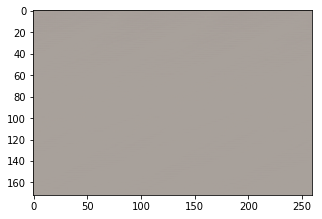

[[[ 0.65130055  0.62923795  0.6013568 ]
  [ 0.65185541  0.62454373  0.59799755]
  [ 0.64874601  0.62249678  0.59893656]
  ..., 
  [ 0.65402752  0.61843169  0.6026957 ]
  [ 0.65018904  0.61675674  0.59963888]
  [ 0.6522972   0.61562812  0.60110193]]

 [[ 0.64903289  0.61728364  0.59750736]
  [ 0.6518715   0.61632878  0.60213709]
  [ 0.64927518  0.61510563  0.60015947]
  ..., 
  [ 0.65408403  0.61876279  0.60297775]
  [ 0.65110999  0.61755186  0.60180271]
  [ 0.65207094  0.61876625  0.60316819]]

 [[ 0.65039605  0.61839849  0.600878  ]
  [ 0.65376431  0.61938864  0.60393387]
  [ 0.65139705  0.61852956  0.60129833]
  ..., 
  [ 0.64707267  0.61992192  0.59392148]
  [ 0.64705193  0.61413664  0.5963617 ]
  [ 0.64894789  0.61801875  0.59741068]]

 ..., 
 [[ 0.66152877  0.63330054  0.60968655]
  [ 0.66107053  0.63401222  0.60982466]
  [ 0.66116822  0.63337457  0.60942411]
  ..., 
  [ 0.66150331  0.63360852  0.61003542]
  [ 0.66134411  0.63358402  0.61006266]
  [ 0.66146207  0.63350385  0.61009

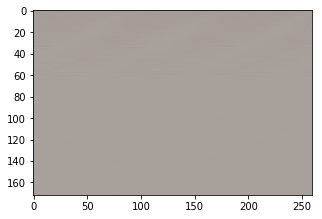

[[[ 0.64082497  0.62427962  0.59734035]
  [ 0.64256954  0.61561161  0.58822858]
  [ 0.63141555  0.61385238  0.58922607]
  ..., 
  [ 0.65452623  0.61871439  0.60104668]
  [ 0.6509645   0.61587936  0.59866166]
  [ 0.65455878  0.61600643  0.59934676]]

 [[ 0.6491425   0.61845922  0.59763068]
  [ 0.6540677   0.61714303  0.60113502]
  [ 0.64943504  0.61746377  0.59928685]
  ..., 
  [ 0.64713931  0.6069448   0.59584379]
  [ 0.64181757  0.6044085   0.59416097]
  [ 0.64527863  0.60564643  0.59763515]]

 [[ 0.6417163   0.60508001  0.59372765]
  [ 0.64637232  0.60806817  0.59774905]
  [ 0.64303249  0.60706002  0.59411967]
  ..., 
  [ 0.65008789  0.62015712  0.59340549]
  [ 0.6527226   0.61589646  0.59784687]
  [ 0.65112734  0.62333298  0.59913898]]

 ..., 
 [[ 0.66101938  0.63308328  0.60900974]
  [ 0.6607911   0.6340794   0.60942203]
  [ 0.66122383  0.63248163  0.6090647 ]
  ..., 
  [ 0.66416919  0.63126147  0.60894948]
  [ 0.66202921  0.63261461  0.60715497]
  [ 0.66356301  0.63175583  0.60918

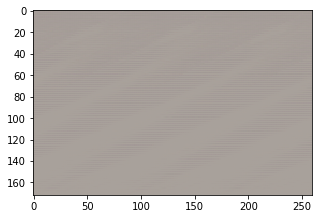

[[[ 0.64111811  0.62440622  0.59748232]
  [ 0.64285052  0.61586684  0.58857226]
  [ 0.63195121  0.61413366  0.58954328]
  ..., 
  [ 0.65210664  0.61591542  0.59974647]
  [ 0.64799392  0.61478609  0.59604412]
  [ 0.65334243  0.61361241  0.60054386]]

 [[ 0.64797789  0.61429089  0.59698808]
  [ 0.65050751  0.61458486  0.60050184]
  [ 0.64754146  0.61400414  0.59744471]
  ..., 
  [ 0.64673311  0.6056425   0.59522676]
  [ 0.64113212  0.60313863  0.59362018]
  [ 0.64406979  0.60460609  0.59752691]]

 [[ 0.64100713  0.60355419  0.59363806]
  [ 0.6458022   0.60698634  0.5972023 ]
  [ 0.64217907  0.60573536  0.59304583]
  ..., 
  [ 0.6435672   0.61351383  0.59004337]
  [ 0.64552778  0.60882062  0.5930081 ]
  [ 0.64639288  0.6167537   0.59431058]]

 ..., 
 [[ 0.66094118  0.63276565  0.60877013]
  [ 0.66054469  0.63374972  0.60904497]
  [ 0.66114038  0.6316458   0.60881758]
  ..., 
  [ 0.66384691  0.63118887  0.60978079]
  [ 0.66169822  0.63291019  0.60767412]
  [ 0.66377354  0.63148201  0.61023

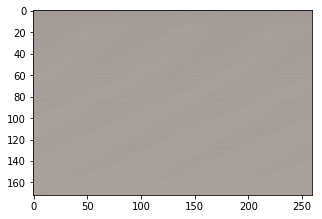

[[[ 0.63523388  0.62170398  0.5938552 ]
  [ 0.63868725  0.61063331  0.58401   ]
  [ 0.62606335  0.60956353  0.5851    ]
  ..., 
  [ 0.64441323  0.60437083  0.59537739]
  [ 0.63988888  0.60334885  0.58945256]
  [ 0.64458978  0.60194236  0.59418446]]

 [[ 0.63875318  0.59910709  0.58992183]
  [ 0.64187616  0.60064662  0.59408259]
  [ 0.63754845  0.59946257  0.58880156]
  ..., 
  [ 0.64332777  0.60084391  0.59350801]
  [ 0.63807297  0.59957904  0.59008282]
  [ 0.64133734  0.60097605  0.59610647]]

 [[ 0.63851893  0.59794998  0.59261513]
  [ 0.64279091  0.60177338  0.59467232]
  [ 0.63840038  0.60016215  0.58957124]
  ..., 
  [ 0.63137835  0.60172862  0.57771379]
  [ 0.63193744  0.59325939  0.58220714]
  [ 0.63606966  0.60271424  0.58383876]]

 ..., 
 [[ 0.66138822  0.63350219  0.61004418]
  [ 0.66151637  0.63349169  0.60996175]
  [ 0.66142327  0.63344538  0.61007255]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

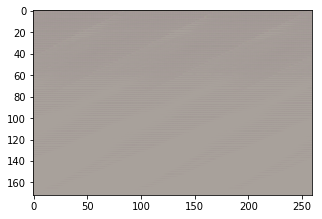

[[[ 0.64960313  0.62826842  0.60108918]
  [ 0.65076447  0.62313402  0.59754294]
  [ 0.64687967  0.62174112  0.59813893]
  ..., 
  [ 0.64670557  0.60671407  0.59628445]
  [ 0.64169949  0.60494721  0.59106559]
  [ 0.64529562  0.60328174  0.59442294]]

 [[ 0.63950723  0.60125911  0.59010452]
  [ 0.64287394  0.60252035  0.59545565]
  [ 0.63907272  0.60118884  0.59070688]
  ..., 
  [ 0.65216255  0.6171791   0.60204041]
  [ 0.64977044  0.61630577  0.60094935]
  [ 0.65119523  0.61606646  0.60263723]]

 [[ 0.64935338  0.61417121  0.60164815]
  [ 0.65086943  0.61705059  0.60267282]
  [ 0.64942074  0.61638409  0.59985816]
  ..., 
  [ 0.63419062  0.60406631  0.58139122]
  [ 0.63174248  0.5978654   0.58525866]
  [ 0.63739175  0.60335177  0.58544219]]

 ..., 
 [[ 0.66053188  0.63243061  0.60788065]
  [ 0.66075808  0.63311279  0.60924494]
  [ 0.66077477  0.63230366  0.60908675]
  ..., 
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006707]
  [ 0.6615175   0.63365382  0.61006

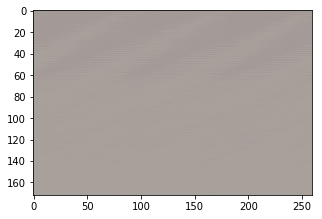

[[[ 0.63539487  0.62177795  0.5939554 ]
  [ 0.63826174  0.61080754  0.58335829]
  [ 0.62496877  0.60920715  0.58454877]
  ..., 
  [ 0.64625871  0.60686171  0.59550792]
  [ 0.64061415  0.60610884  0.58995122]
  [ 0.64787322  0.60505033  0.59693146]]

 [[ 0.64147377  0.60461253  0.59125608]
  [ 0.64502287  0.60481751  0.5959301 ]
  [ 0.64069486  0.60325682  0.59178418]
  ..., 
  [ 0.64331841  0.60118562  0.59348112]
  [ 0.63792247  0.59943652  0.58997452]
  [ 0.64205796  0.60131878  0.595824  ]]

 [[ 0.63853663  0.59929752  0.59130532]
  [ 0.6435014   0.60268366  0.594841  ]
  [ 0.63892215  0.60121548  0.58946383]
  ..., 
  [ 0.63493323  0.60597765  0.58111316]
  [ 0.63571316  0.59783286  0.58517838]
  [ 0.6385355   0.60649443  0.58624935]]

 ..., 
 [[ 0.66067487  0.63206679  0.60787505]
  [ 0.65988207  0.63277537  0.60832036]
  [ 0.66075569  0.62980694  0.60902184]
  ..., 
  [ 0.66379702  0.63127834  0.60942775]
  [ 0.66131163  0.63312083  0.60721219]
  [ 0.66383886  0.63106614  0.61076

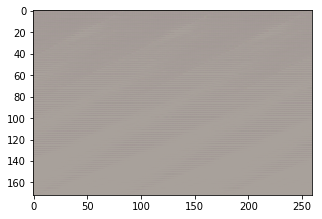

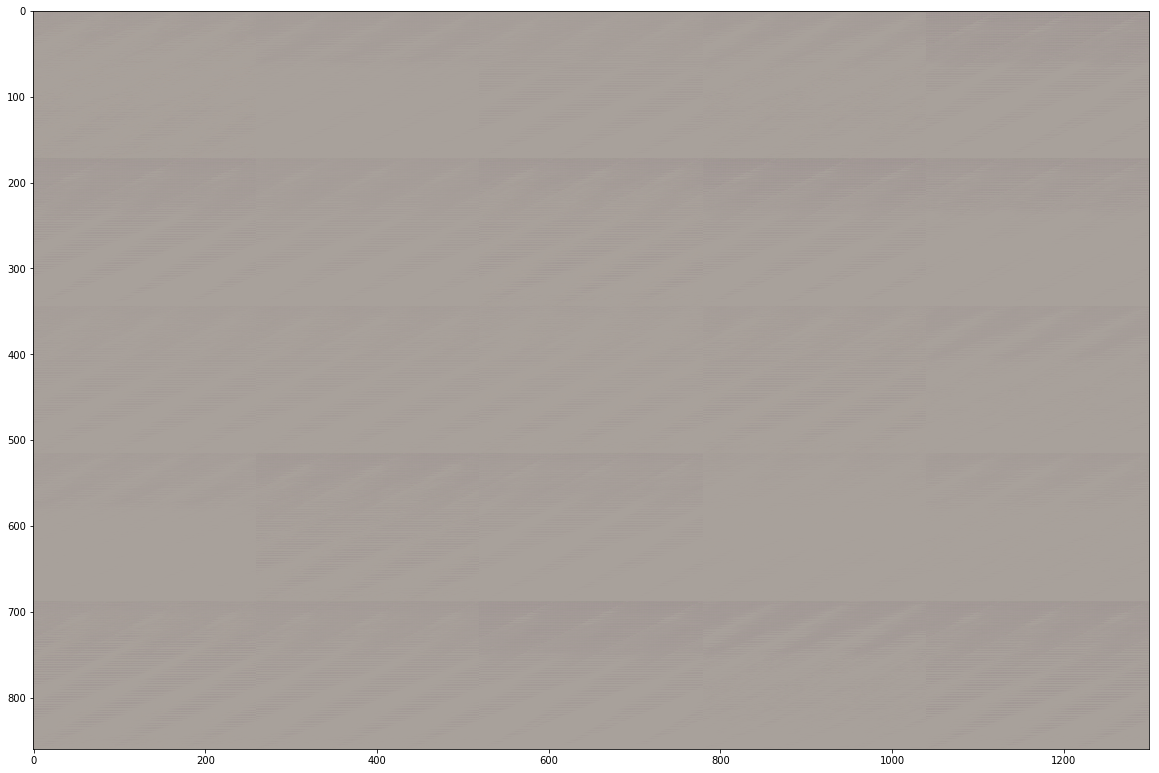

In [37]:
# display images generated from randomly sampled latent vector
n = 5
figure = np.zeros((img_cols * n, img_rows * n, img_chns))


for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1,size=latent_dim)])
        #print(z_sample)
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_cols, img_rows, img_chns)
        print(img)
        figure[i * img_cols: (i + 1) * img_cols, j * img_rows: (j + 1) * img_rows] = img

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
#plt.imshow(figure)
#plt.show()